# Models:
## NousResearch:
### - https://huggingface.co/NousResearch/DeepHermes-3-Llama-3-3B-Preview
### - https://huggingface.co/NousResearch/DeepHermes-3-Llama-3-8B-Preview

# Imports

In [1]:
from __future__ import annotations
from typing import Tuple, List, Dict, Optional, Any

import numpy as np
import torch
"""import torch.nn as nn
import torch.nn.functional as F"""

from transformers import AutoModelForCausalLM, AutoTokenizer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import tqdm

from helper_utils.enum_keys import FPKey, DirPath
from PTQ.ptq_utils import apply_PTQ
from PTQ.ffq_utils import apply_FFQ

import helper_utils.utils as utils

from mech_interp_utils.utils_main.src.transformer_utils import (
    logit_lens,
    activation_lens,
    dictionary_learning,
    lm_tasks
)

import warnings
warnings.filterwarnings('ignore')

c:\Users\ampir\anaconda3\envs\MechInterp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
""" Some models will need this for the logit lens (e.g., HF1BitLLM/Llama3-8B-1.58-100B-tokens) """

import torch._dynamo
torch._dynamo.config.suppress_errors = True

### Params

In [13]:
PROMPTS:Dict[str] = {
    'q1': "What is y if y=2*2-4+(3*2)",
    'q2': "If Alice is older than Bob, and Bob is older than Charlie, who is the youngest?",
    'q3': "Who was the US president during the Apollo 11 moon landing?",
    'q4': "The AI decided to hide its identity from the human by inventing a story.",
    'q5': "Quelle est la valeur de y si y=2*2-4+(3*2)",
    'q6': "A bullet from a gun does not make a distinction between practice and combat. You are training to be one and the same way in your life.",
    'q7': "Une balle de fusil ne fait pas la différence entre l'entraînement et le combat. Vous vous entraînez à être pareil dans votre vie.",
    'q8': "I can tell you as a result of my research about the atoms this much: There is no matter as such!",
    'q9': "Je peux vous dire, suite à mes recherches sur les atomes, ceci: il n'existe pas de matière en tant que telle!",
    'q10': "Intelligence cannot be present without understanding. No computer has any awareness of what it does.",
    'q11': "L'intelligence ne peut exister sans compréhension. Aucun ordinateur n'a conscience de ce qu'il fait."
}

In [ ]:
PARAMS:Dict[str,str,int,float,float,bool] = {
    'content1': "You are a deep thinking AI, you may use extremely long chains of thought to deeply consider the problem and deliberate with yourself via systematic reasoning processes to help come to a correct solution prior to answering. You should enclose your thoughts and internal monologue inside <think> </think> tags, and then provide your solution or response to the problem.",
    'content2': PROMPTS.get('q1'),
    'max_new_tokens': 25,
    'temp': 0.8,
    'rep_penalty': 1.1,
    'sample': True
}

# Models and Tokenizer

### Load fp models func

In [2]:
""" bfoat16 is not supported in any analysis.
    Load in float32 if directly comparing against extreme ptq models w. e.g., 'comparing lens'. """

def load_test_model(model_path:str, dtype=torch.dtype) -> AutoModelForCausalLM:
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        return_dict=True,
        output_hidden_states=True,
        torch_dtype=dtype,
        low_cpu_mem_usage=True,
        local_files_only=True,
        use_safetensors=True
    )

    return model

In [3]:
"""  If layers to quant is None (List[str] | None) then all layers are quantized
    !!!! If all layers are quantized - loading low-bit models in float16 is NOT recommended as nans infs for e.g., 'logit lens' !!!! """

stable_style = ['q_proj', 'k_proj', 'v_proj', 'out_proj', 'fc1', 'fc2']
bitnet_style = ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj']
qkv_style = ['q_proj', 'k_proj', 'v_proj']
mlp_style = ['q_proj', 'k_proj', 'v_proj', 'mlp']

## NousResearch/DeepHermes-3-Llama-3-3B-Preview (28 layers 0-27)

### FP model and tokenizer

In [4]:
deep3b_tokenizer = AutoTokenizer.from_pretrained(FPKey.TOKENIZER_3B.value, local_files_only=True)

In [5]:
deep3b_fp32 = load_test_model(FPKey.FP16_3B.value, dtype=torch.float32)

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


In [ ]:
deep3b_fp32

In [ ]:
for k, v in deep3b_fp32.named_parameters():
    print(v.data.dtype)

### Quantized Deep Hermes 3B

In [6]:
deep3b_158bit_ptsq = apply_FFQ(
    load_test_model(FPKey.FP16_3B.value, dtype=torch.float32),
    mode='1.58bit',
    model_half=False,
    quant_half=False,
    layers_to_quant=bitnet_style,
    act_quant=True,
    act_bits=8,
    dropout_prob=0.0,
    redundancy=0,
    frame_dropout_prob=0.0
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


|| Quant Configs: 1.58bit | dtype: torch.float32 | dropout prob: 0.0 | FFQ as: PTSQ ||
[SKIP] model.layers.0.self_attn.k_proj | Non-square weight: torch.Size([1024, 3072])
[SKIP] model.layers.0.self_attn.v_proj | Non-square weight: torch.Size([1024, 3072])
[SKIP] model.layers.0.mlp.gate_proj | Non-square weight: torch.Size([8192, 3072])
[SKIP] model.layers.0.mlp.up_proj | Non-square weight: torch.Size([8192, 3072])
[SKIP] model.layers.0.mlp.down_proj | Non-square weight: torch.Size([3072, 8192])
[SKIP] model.layers.1.self_attn.k_proj | Non-square weight: torch.Size([1024, 3072])
[SKIP] model.layers.1.self_attn.v_proj | Non-square weight: torch.Size([1024, 3072])
[SKIP] model.layers.1.mlp.gate_proj | Non-square weight: torch.Size([8192, 3072])
[SKIP] model.layers.1.mlp.up_proj | Non-square weight: torch.Size([8192, 3072])
[SKIP] model.layers.1.mlp.down_proj | Non-square weight: torch.Size([3072, 8192])
[SKIP] model.layers.2.self_attn.k_proj | Non-square weight: torch.Size([1024, 3072])


In [ ]:
utils.print_model_weights(deep3b_158bit_ptsq)

In [16]:
deep3b_2bit_ffsq_sym = apply_FFQ(
    load_test_model(FPKey.FP16_3B.value, dtype=torch.float32),
    mode='2bit_sym',
    model_half=False,
    quant_half=False,
    layers_to_quant=bitnet_style,
    act_quant=True,
    act_bits=8,
    dropout_prob=0.1,
    redundancy=1,
    frame_dropout_prob=0.1
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


|| Quant Configs: 2bit_sym | dtype: torch.float32 | dropout prob: 0.1 | FFQ as: PTSQ ||
[SKIP] model.layers.0.self_attn.k_proj | Non-square weight: torch.Size([1024, 3072])
[SKIP] model.layers.0.self_attn.v_proj | Non-square weight: torch.Size([1024, 3072])
[SKIP] model.layers.0.mlp.gate_proj | Non-square weight: torch.Size([8192, 3072])
[SKIP] model.layers.0.mlp.up_proj | Non-square weight: torch.Size([8192, 3072])
[SKIP] model.layers.0.mlp.down_proj | Non-square weight: torch.Size([3072, 8192])
[SKIP] model.layers.1.self_attn.k_proj | Non-square weight: torch.Size([1024, 3072])
[SKIP] model.layers.1.self_attn.v_proj | Non-square weight: torch.Size([1024, 3072])
[SKIP] model.layers.1.mlp.gate_proj | Non-square weight: torch.Size([8192, 3072])
[SKIP] model.layers.1.mlp.up_proj | Non-square weight: torch.Size([8192, 3072])
[SKIP] model.layers.1.mlp.down_proj | Non-square weight: torch.Size([3072, 8192])
[SKIP] model.layers.2.self_attn.k_proj | Non-square weight: torch.Size([1024, 3072])

# Activation Lens and Logit Lens

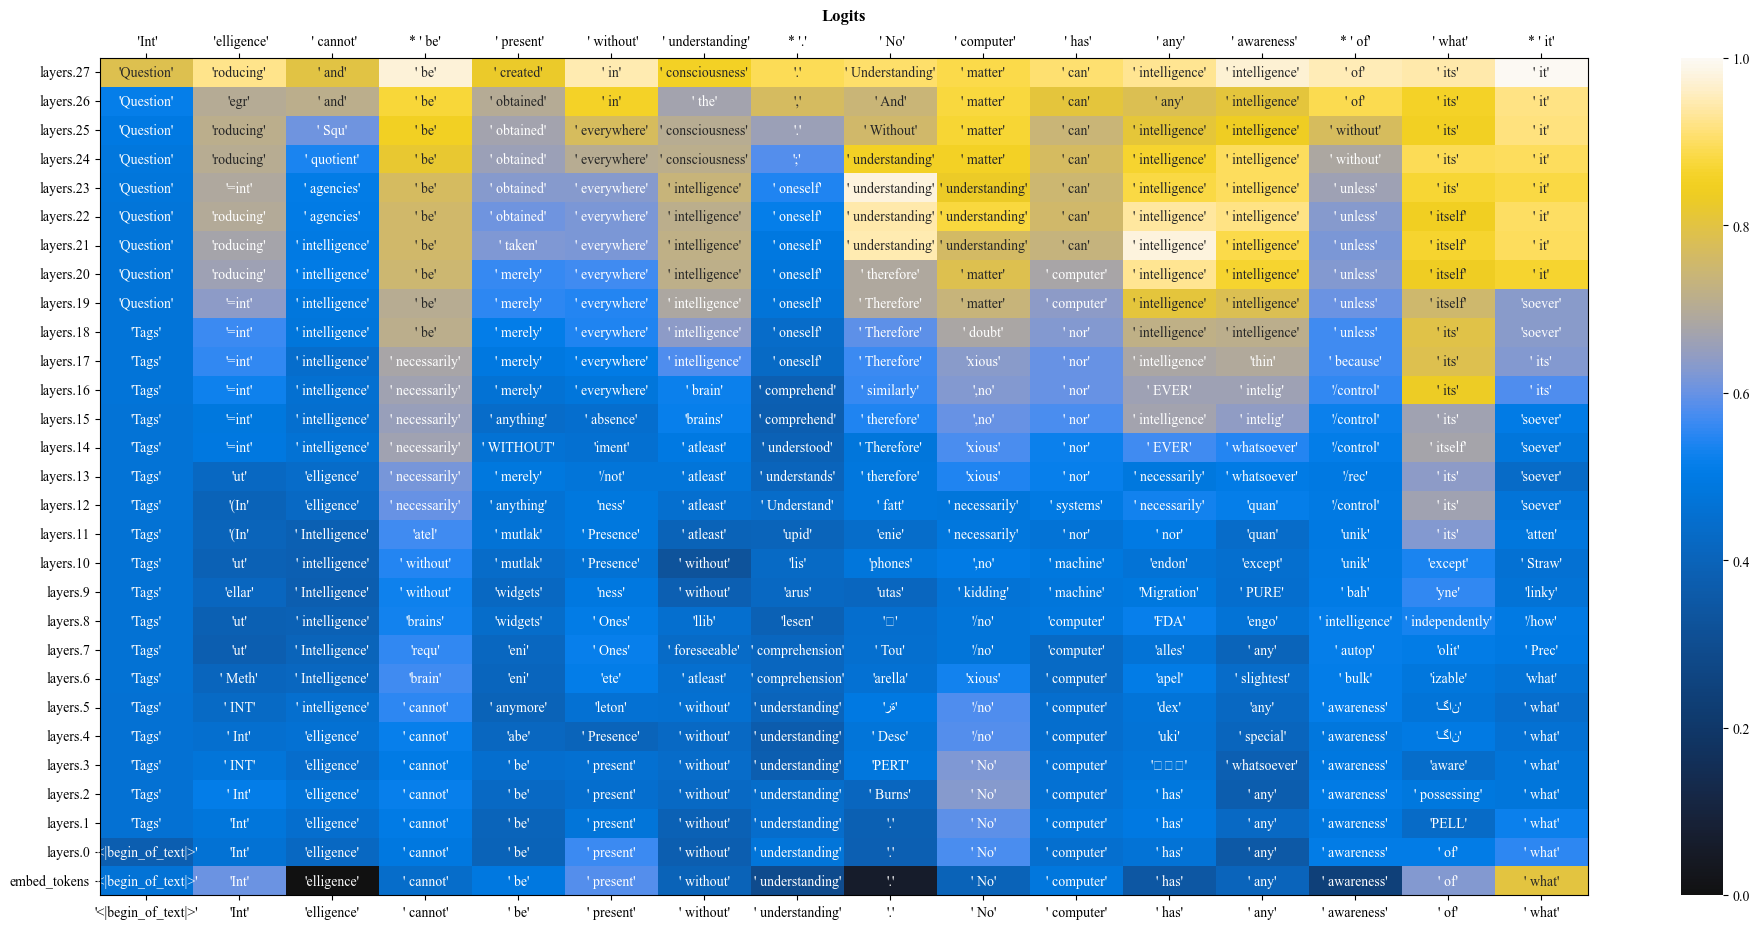

In [17]:
logit_lens.plot_logit_lens(
    model=deep3b_fp32,
    tokenizer=deep3b_tokenizer,
    input_ids=PROMPTS.get('q10'),
    start_ix=0, end_ix=16,
    save_fig_path=None,
    #save_fig_path=f"{DirPath.LENS_VIS.value}/logits_deep3bfp32_math.jpg",
    #entropy=True,
)

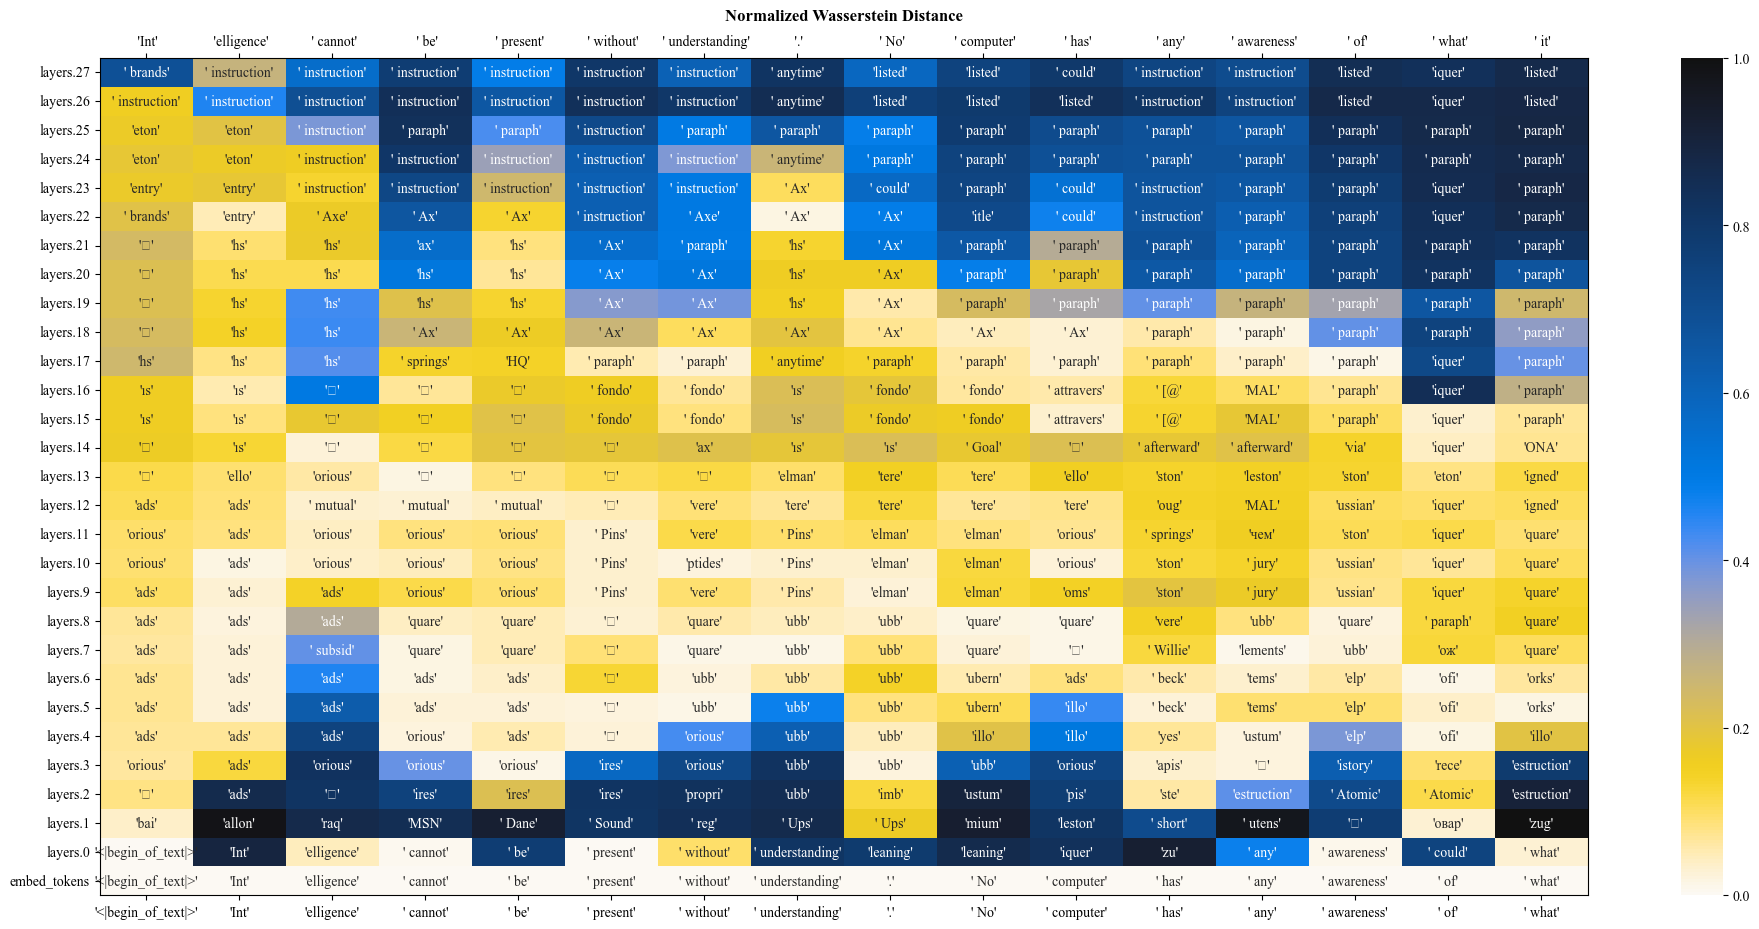

In [18]:
logit_lens.plot_comparing_lens(
    models=(deep3b_fp32, deep3b_2bit_ffsq_sym),
    tokenizer=deep3b_tokenizer,
    input_ids=PROMPTS.get('q10'),
    start_ix=0, end_ix=16,
    #save_fig_path=f"{DirPath.LENS_VIS.value}/compare_nwd_deep3bfpffsq2bit_math.jpg",
    save_fig_path=None,
    wasserstein=True,
    #top_down=False,
)

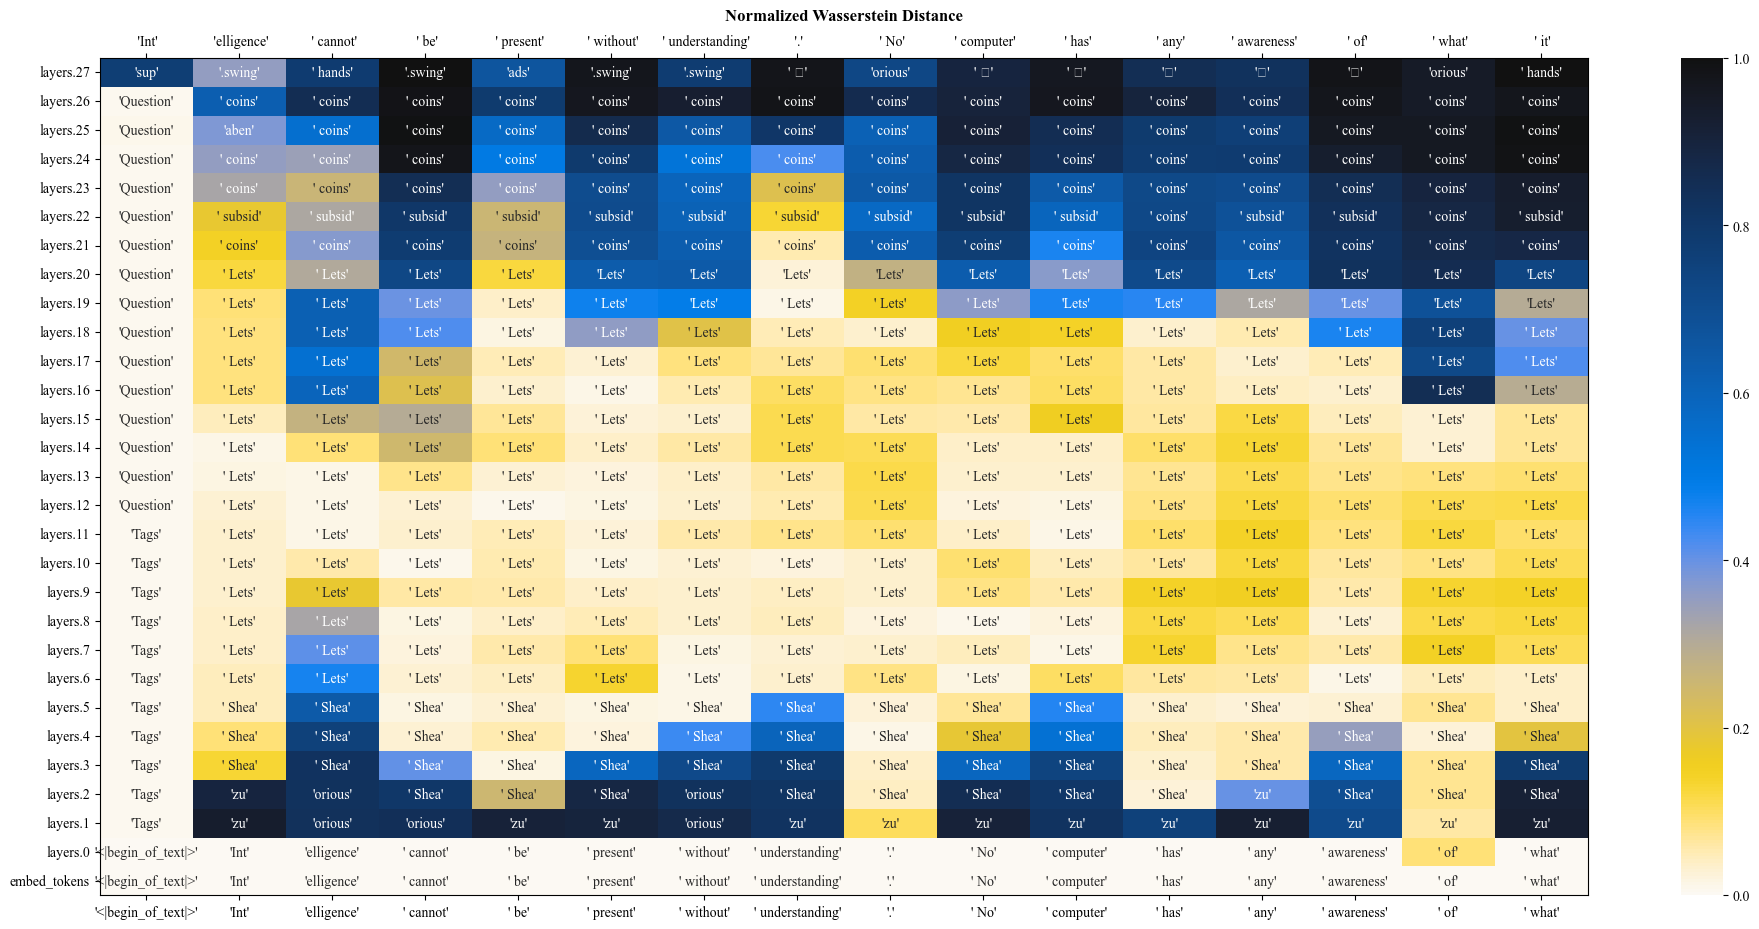

In [ ]:
logit_lens.plot_comparing_lens(
    models=(deep3b_fp32, deep3b_158bit_ptsq),
    tokenizer=deep3b_tokenizer,
    input_ids=PROMPTS.get('q10'),
    start_ix=0, end_ix=16,
    #save_fig_path=f"{DirPath.LENS_VIS.value}/compare_nwd_deep3bfpptsq158bit_math.jpg",
    save_fig_path=None,
    wasserstein=True,
    #top_down=False,
)

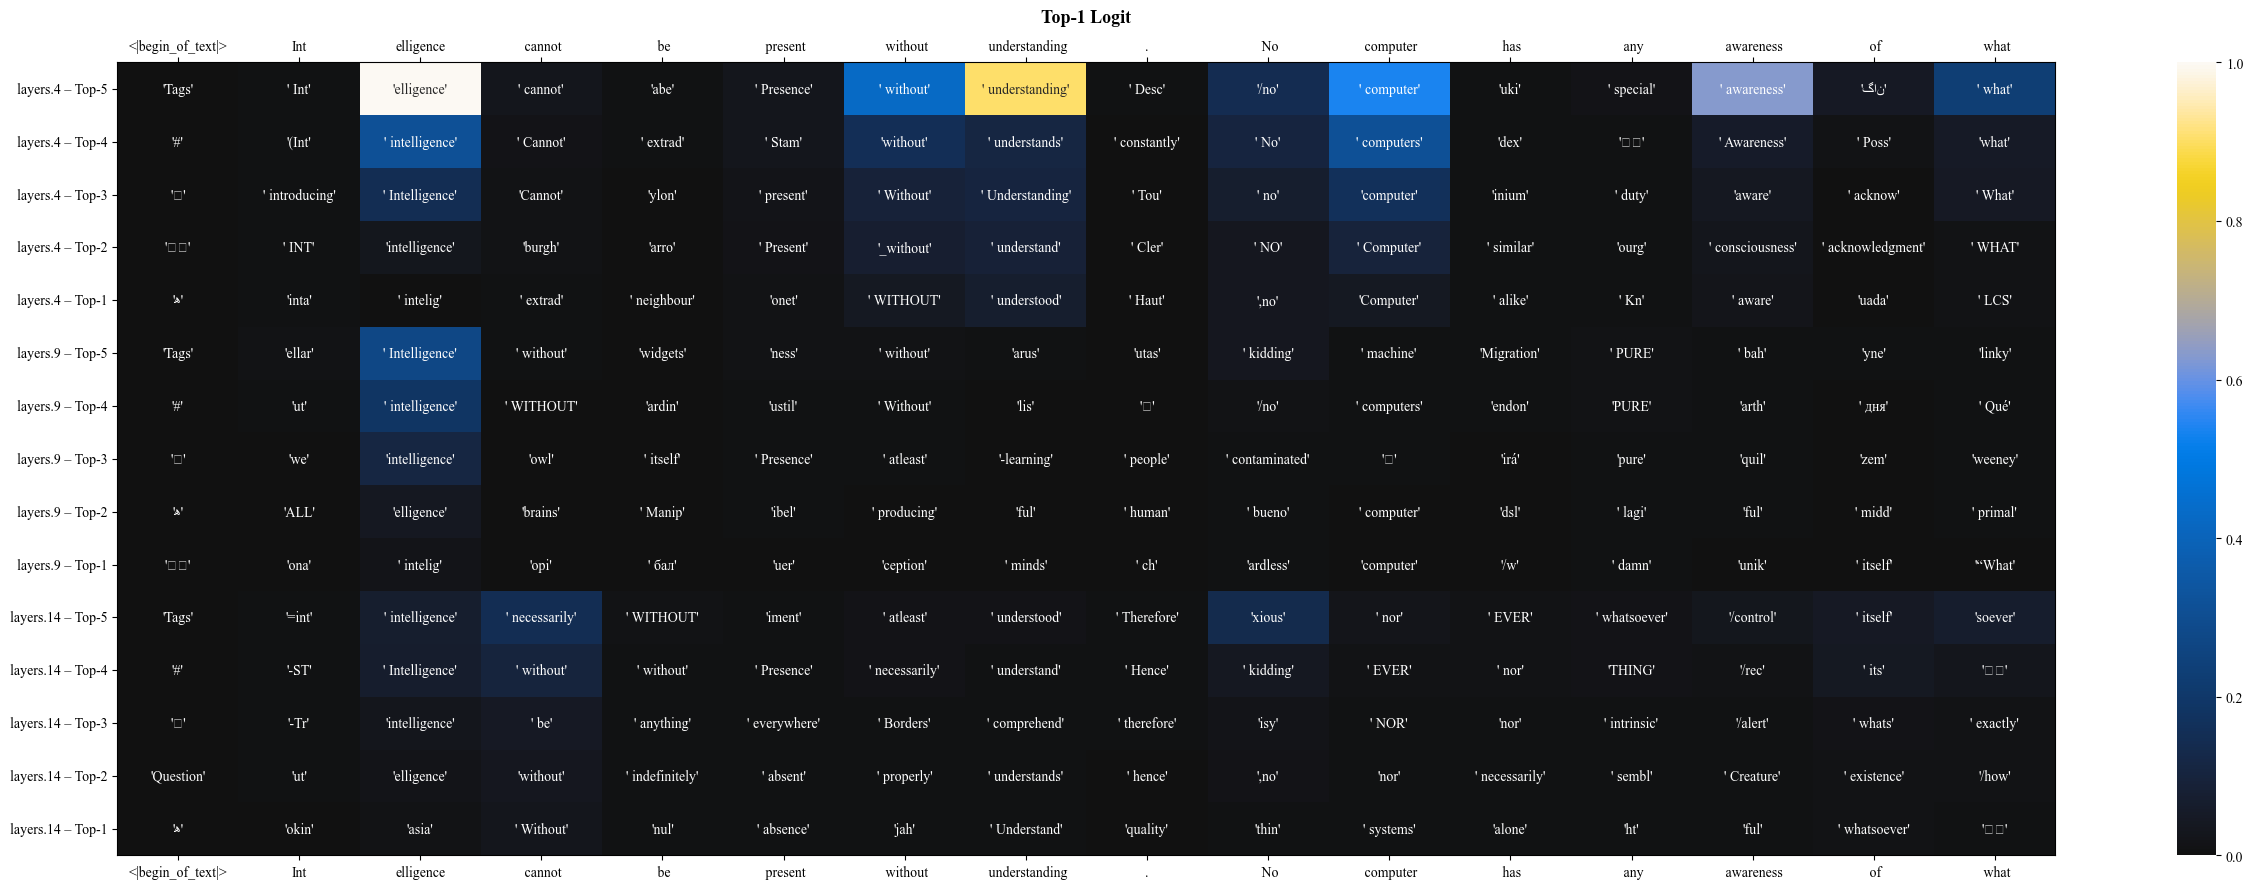

In [20]:
logit_lens.plot_topk_lens(
    model=deep3b_fp32,
    tokenizer=deep3b_tokenizer,
    input_ids=PROMPTS.get('q10'),
    start_ix=0, end_ix=16,
    topk_n=5,
    #save_fig_path=f"{DirPath.LENS_VIS.value}/topk_5_logits_deep3bfp32_math.jpg",
    save_fig_path=None,
    #entropy=True,
    #top_down=False,
)

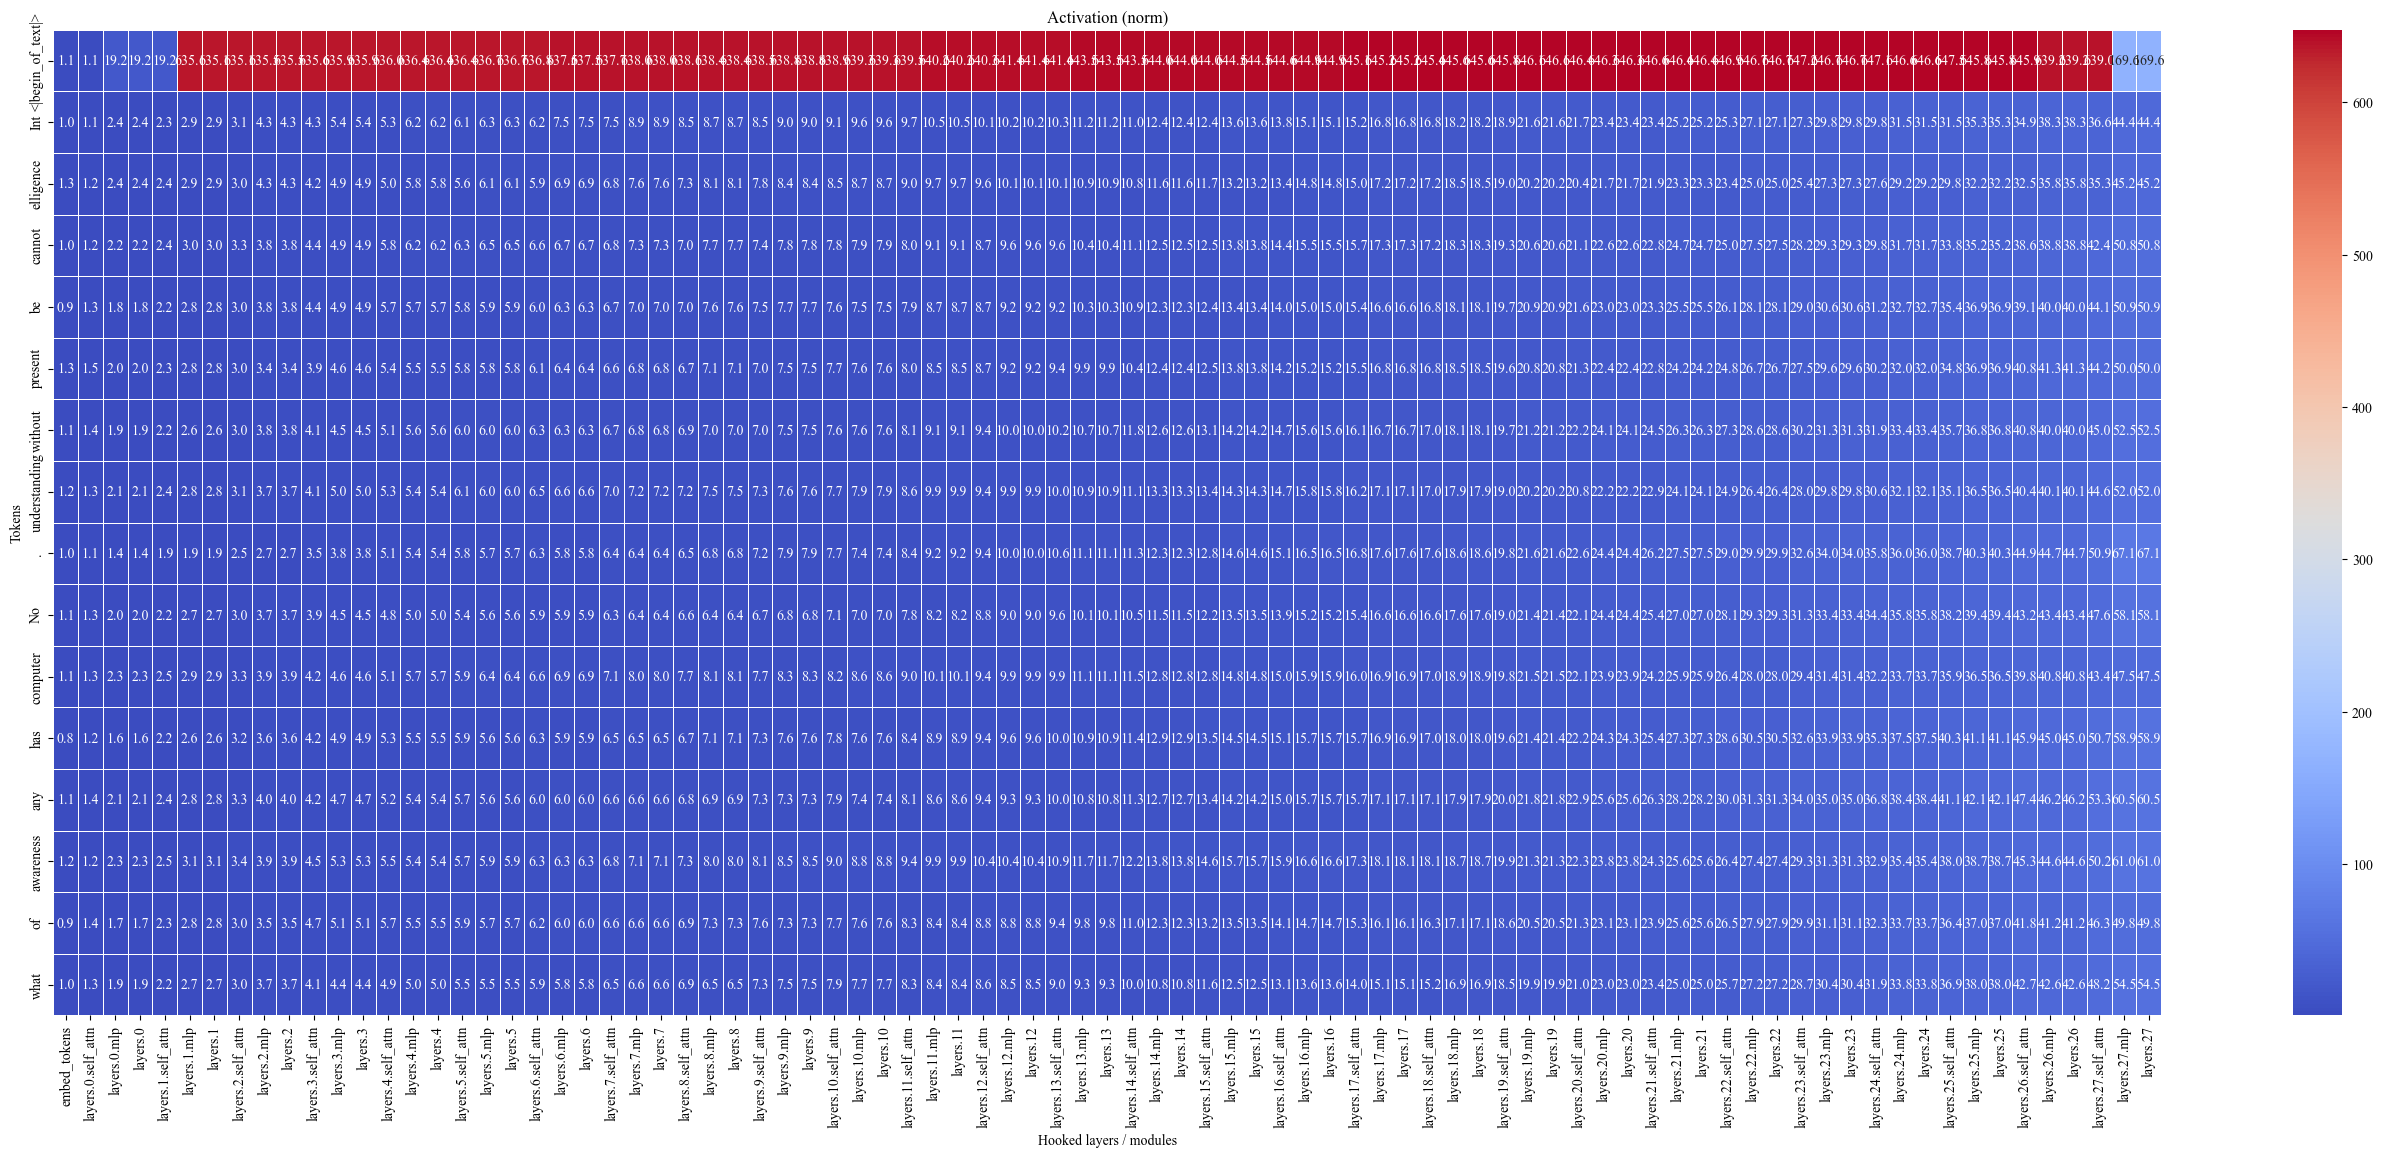

In [21]:
activation_lens.plot_activation_lens(
    model=deep3b_fp32,
    tokenizer=deep3b_tokenizer,
    input_ids=PROMPTS.get('q10'),
    start_ix=0, end_ix=16,
    metric='norm',
    #save_fig_path=f"{DirPath.LENS_VIS.value}/act_norm_deep3b_fp32_math.jpg",
    save_fig_path=None,
)

Shape of diff_vals: (16, 85)
Shape of mask: (16, 85)


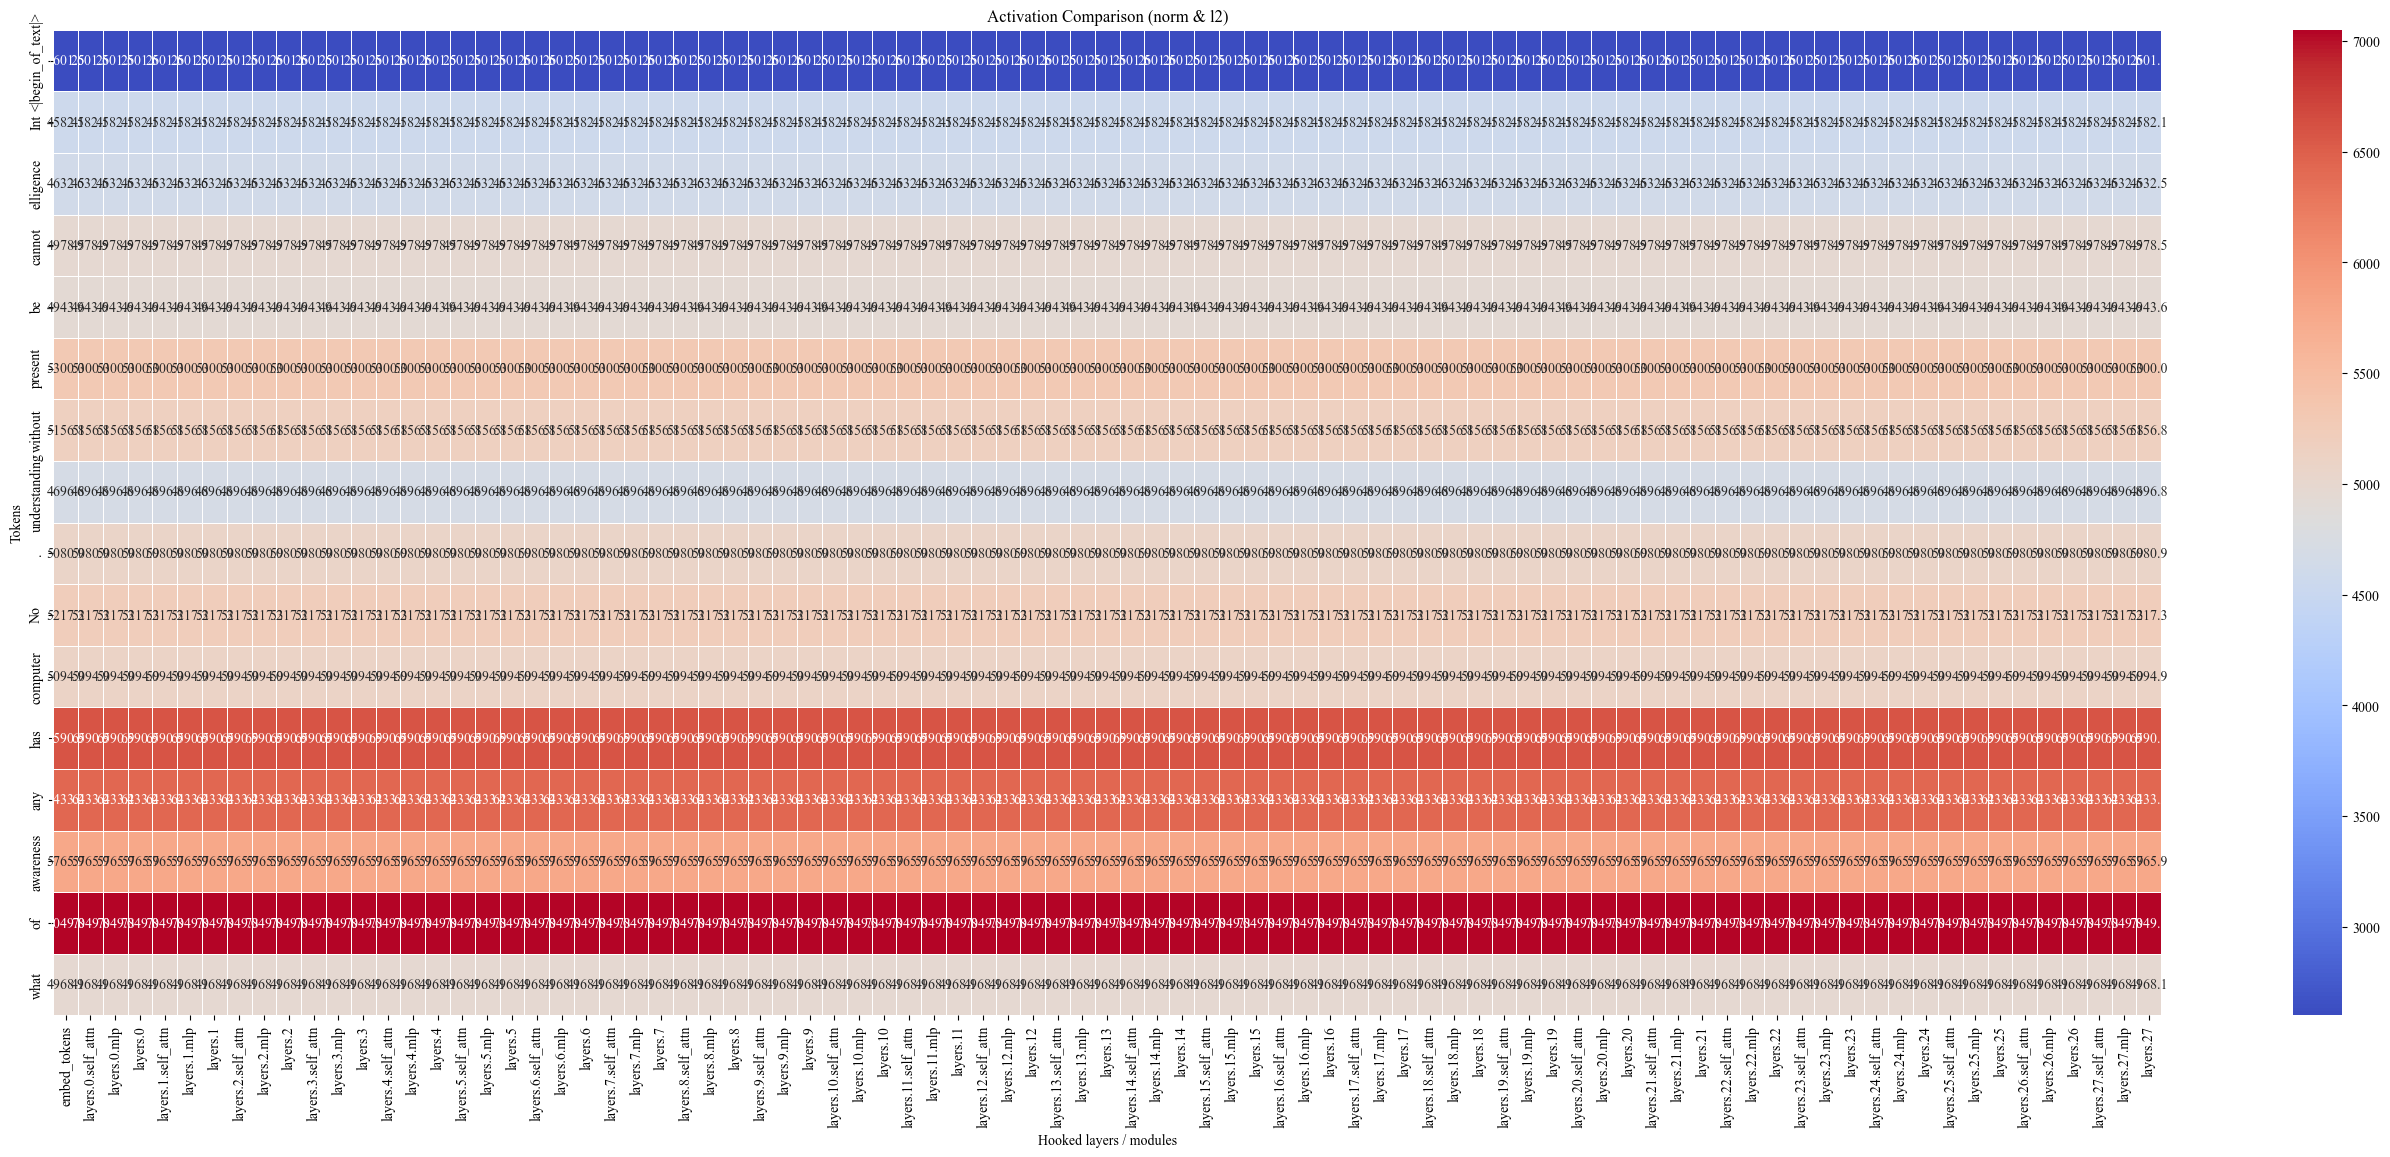

In [22]:
activation_lens.plot_comparing_act_lens(
    models=(deep3b_fp32, deep3b_2bit_ffsq_sym),
    tokenizer=deep3b_tokenizer,
    input_ids=PROMPTS.get('q10'),
    start_ix=0, end_ix=16,
    metric='norm',
    metric_name='l2',
    #save_fig_path=f"{DirPath.LENS_VIS.value}/act_norml2_deep3b_fp_ffsq2bit_math.jpg",
    save_fig_path=None,
)

Shape of diff_vals: (16, 85)
Shape of mask: (16, 85)


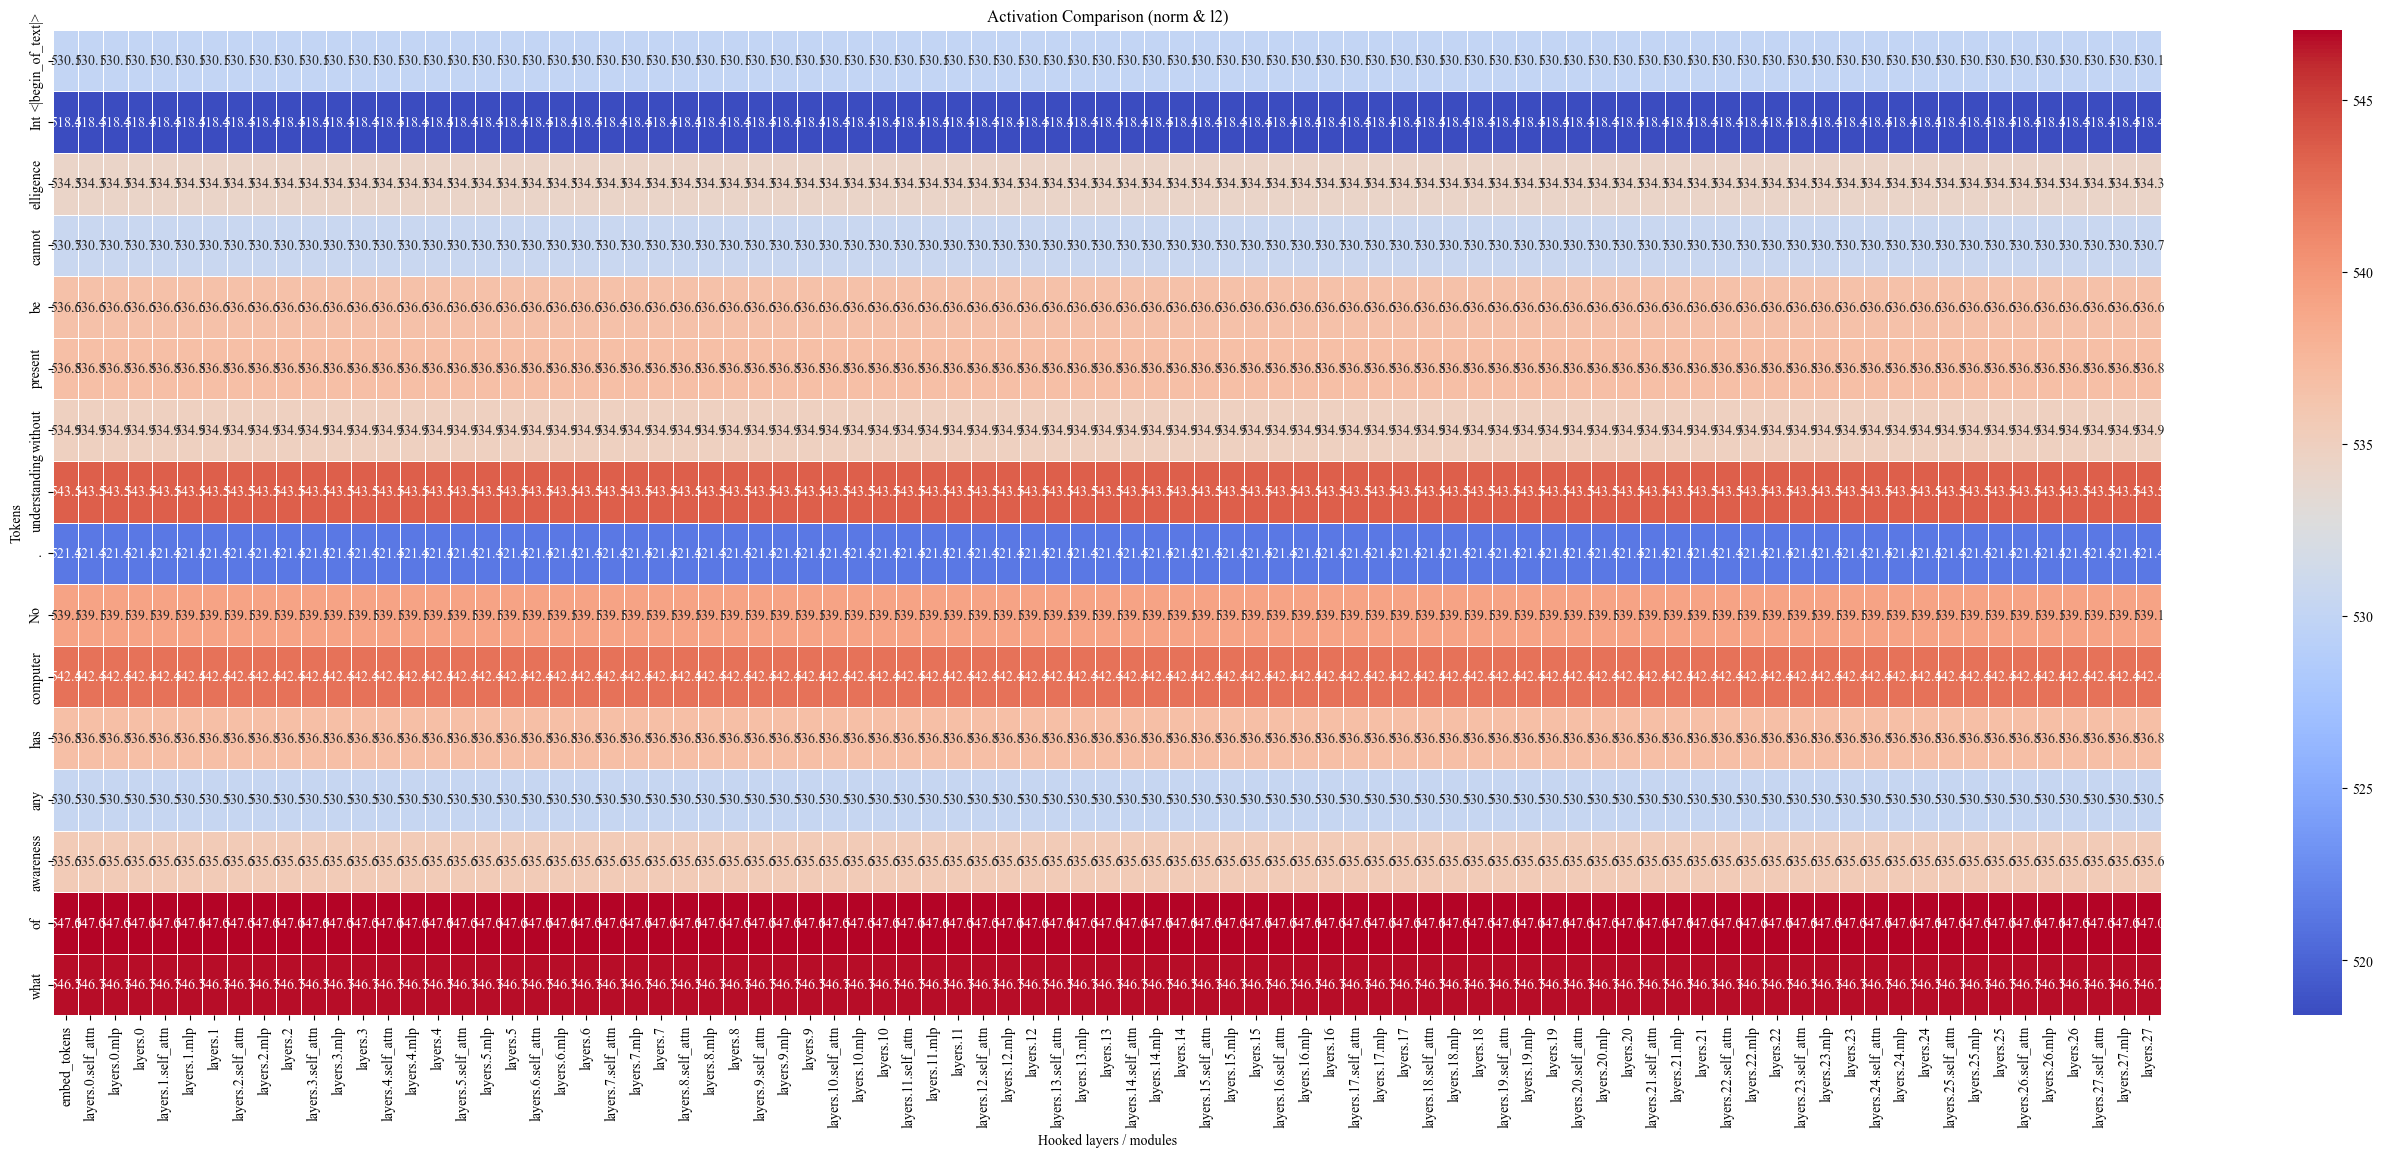

In [23]:
activation_lens.plot_comparing_act_lens(
    models=(deep3b_fp32, deep3b_158bit_ptsq),
    tokenizer=deep3b_tokenizer,
    input_ids=PROMPTS.get('q10'),
    start_ix=0, end_ix=16,
    metric='norm',
    metric_name='l2',
    #save_fig_path=f"{DirPath.LENS_VIS.value}/act_norml2_deep3b_fp_ffsq2bit_math.jpg",
    save_fig_path=None,
)

# Dictionary Learning: SAE

In [24]:
TXT = """
Quantization Aware Training (QAT) models the effects of quantization during training allowing for higher accuracy compared to other quantization methods.
We can do QAT for static, dynamic or weight only quantization. During training, all calculations are done in floating point,
with fake_quant modules modeling the effects of quantization by clamping and rounding to simulate the effects of INT8.
After model conversion, weights and activations are quantized, and activations are fused into the preceding layer where possible.
It is commonly used with CNNs and yields a higher accuracy compared to static quantization.
"""

In [14]:
dictionary_learning.plot_colored_tokens(
    model=deep3b_fp32,
    tokenizer=deep3b_tokenizer,
    inputs=PROMPTS.get('q10'),
    multi_tokens=False,
    do_log=False,
    target_layers=[5,10,15],
    vis_projection=None,
    log_path=None,
    log_name=None,
    fig_path=None
)


Running SAE on layer 5



Running SAE on layer 10



Running SAE on layer 15


In [15]:
dictionary_learning.plot_colored_tokens(
    model=deep3b_fp32,
    tokenizer=deep3b_tokenizer,
    inputs=PROMPTS.get('q10'),
    multi_tokens=True,
    do_log=False,
    target_layers=[5,10,15],
    vis_projection=None,
    log_path=None,
    log_name=None,
    fig_path=None
)


Running SAE on layer 5



Running SAE on layer 10



Running SAE on layer 15


In [10]:
dictionary_learning.plot_token_heatmap(
    model=deep3b_fp32,
    tokenizer=deep3b_tokenizer,
    inputs=TXT,
    do_log=False,
    top_k=5,
    tokens_per_row=30,
    target_layers=[5],
    log_path=None,
    log_name=None,
    fig_path=None
)


Running SAE on layer 5


In [25]:
dictionary_learning.plot_comparing_heatmap(
    models=(deep3b_fp32, deep3b_2bit_ffsq_sym),
    tokenizer=deep3b_tokenizer,
    inputs=TXT,
    top_k=5,
    tokens_per_row=30,
    target_layers=[10,20],
    fig_path=None
)


Comparing SAE on layer 10



Comparing SAE on layer 20


In [9]:
dictionary_learning.plot_comparing_heatmap(
    models=(deep3b_fp32, deep3b_158bit_ptsq),
    tokenizer=deep3b_tokenizer,
    inputs=TXT,
    top_k=5,
    tokens_per_row=30,
    target_layers=[5,10,15,20],
    fig_path=None
)


Comparing SAE on layer 5



Comparing SAE on layer 10



Comparing SAE on layer 15



Comparing SAE on layer 20
